<h3> Building a logistic regression model

In [1065]:
# Credit for some ideas to Usman Malik, Python tutorials blog at:  https://wellsr.com/python/employee-attrition-prediction-with-scikit-learn/

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler 

from sklearn.inspection import permutation_importance


<h4>Select data  NYT x ON KOKO df ilman attrition labelia ja job titlea

In [1093]:
df = pd.read_csv('train.csv')

#Change education level from string to number, 1 = BSc, 2 = MSc or MBA, 3 = DSc or PhD
df['education_level'] = df['education_level'].map({"BSc":1,"MSc or MBA":2, "DSc or PhD":3})

df['hierarchy_level'] = df["job_title"].map(lambda x: 1 if ("Lead" in x or "Principal" in x) else 2 if ("Senior" in x or "Consultant" in x) else 4 if ("Junior designer" in x or "Business" in x or "Junior developer" in x) else 3 if ('Associate' in x or 'Developer' in x or "Designer" in x) else 0)
# 1:Software development, 2: Consulting, 3: Design
df['org_role'] = df["job_title"].map(lambda x: 1 if ("Developer" in x or "developer" in x) else 2 if ("Associate" in x or "Consultant" in x or "Business" in x) else 3 if ("Designer" in x or "designer" in x) else 0).astype(int)

x = df
x = x.drop(['attrition'], axis=1)
x = x.drop(['job_title'], axis=1)

df['traveldays_per_year'].median()

df.tail()

,attrition,training_spend,education_level,job_title,gender_male,performance_rating,boss_rating_avg,salary,overtime_per_week,traveldays_per_year,lastpromotion_months,salary_difference,hierarchy_level,org_role
1726,False,2041,2,Designer,False,4,3.4,4827,9,36,21,-20.651515,3,3
1727,False,1860,2,Associate,False,3,2.6,5268,0,6,26,184.655172,3,2
1728,True,2083,1,Developer,True,4,4.2,6041,12,7,36,-6.771429,3,1
1729,False,1735,1,Business analyst,True,3,2.3,3926,1,19,6,-16.767677,4,2
1730,False,1979,2,Developer,True,1,1.1,5181,2,23,3,-416.483333,3,1


<h4>Data analysis

In [1067]:
df.corr()


C:\Users\Tuomo\AppData\Local\Temp\ipykernel_7108\1886530979.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,attrition,training_spend,education_level,gender_male,performance_rating,boss_rating_avg,salary,overtime_per_week,traveldays_per_year,lastpromotion_months,salary_difference,hierarchy_level,org_role
attrition,1.000000,-0.105297,0.033197,0.015901,-0.155071,-0.115883,-0.071524,0.142209,0.089071,0.173460,-0.102843,0.040336,-0.001651
training_spend,-0.105297,1.000000,-0.012298,0.015620,0.303874,-0.003091,0.083085,0.034568,-0.014164,0.028012,0.158581,-0.036955,-0.022688
education_level,0.033197,-0.012298,1.000000,-0.009912,-0.021048,0.034968,0.156767,0.037720,-0.006499,0.024126,-0.026199,-0.199591,0.074942
gender_male,0.015901,0.015620,-0.009912,1.000000,0.026724,-0.008158,0.157856,0.003474,0.002786,-0.004339,-0.009798,-0.146949,-0.089230
performance_rating,-0.155071,0.303874,-0.021048,0.026724,1.000000,0.017359,0.170632,0.017795,-0.002407,0.021153,0.521642,-0.017183,0.014215
boss_rating_avg,-0.115883,-0.003091,0.034968,-0.008158,0.017359,1.000000,-0.001677,-0.025239,-0.003184,0.006308,0.001990,0.012464,0.005050
salary,-0.071524,0.083085,0.156767,0.157856,0.170632,-0.001677,1.000000,0.018061,-0.027302,0.028679,0.115450,-0.944787,-0.205713
overtime_per_week,0.142209,0.034568,0.037720,0.003474,0.017795,-0.025239,0.018061,1.000000,0.023819,0.047945,0.068486,-0.006295,-0.009471
traveldays_per_year,0.089071,-0.014164,-0.006499,0.002786,-0.002407,-0.003184,-0.027302,0.023819,1.000000,-0.025889,-0.026755,0.021495,0.040483
lastpromotion_months,0.173460,0.028012,0.024126,-0.004339,0.021153,0.006308,0.028679,0.047945,-0.025889,1.000000,-0.002680,-0.015055,-0.042980


No significant correlations with attrition. Outside that, only the salary difference is somewhat correlated with performance rating (0.5 correlation).

<AxesSubplot: xlabel='job_title'>

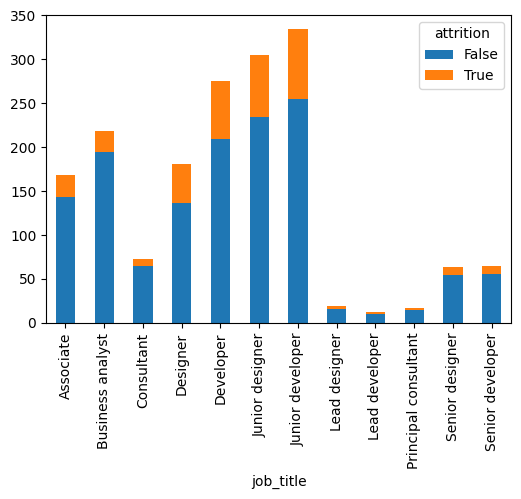

In [1068]:

df.groupby(['job_title', 'attrition']).size().unstack().plot(kind='bar',
                                                                                stacked=True,
                                                                              figsize=(6, 4))

C:\Users\Tuomo\AppData\Local\Temp\ipykernel_7108\269028689.py:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  norm_counts = counts.groupby(level=1).apply(lambda x: x/x.sum())


<AxesSubplot: xlabel='performance_rating'>

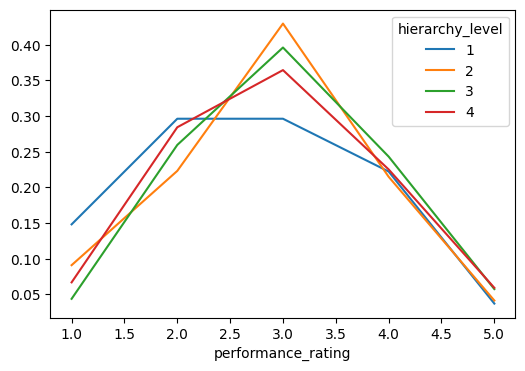

In [1086]:
counts = df.groupby(['performance_rating', 'hierarchy_level']).size()
norm_counts = counts.groupby(level=1).apply(lambda x: x/x.sum())
norm_counts.unstack().plot(kind='line', stacked=False, figsize=(6, 4))

C:\Users\Tuomo\AppData\Local\Temp\ipykernel_7108\973394445.py:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  norm_counts = counts.groupby(level=1).apply(lambda x: x/x.sum())


<AxesSubplot: xlabel='traveldays_per_year'>

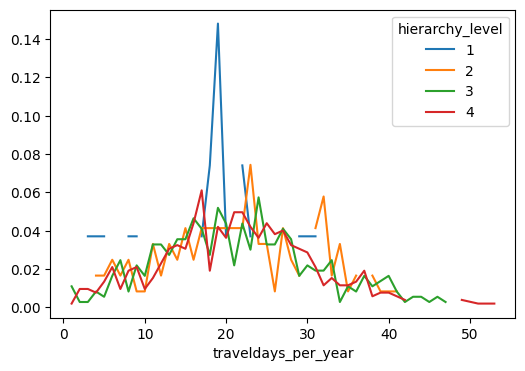

In [1092]:
counts = df.groupby(['traveldays_per_year', 'hierarchy_level']).size()
norm_counts = counts.groupby(level=1).apply(lambda x: x/x.sum())
norm_counts.unstack().plot(kind='line', stacked=False, figsize=(6, 4))

In [ ]:
fit_logistic_std = sm.Logit(y_train, X_standardized).fit()
print(fit_logistic_std.summary())

Optimization terminated successfully.
         Current function value: 0.443693
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              attrition   No. Observations:                 1731
Model:                          Logit   Df Residuals:                     1718
Method:                           MLE   Df Model:                           12
Date:                Wed, 15 Mar 2023   Pseudo R-squ.:                  0.1102
Time:                        23:27:43   Log-Likelihood:                -768.03
converged:                       True   LL-Null:                       -863.14
Covariance Type:            nonrobust   LLR p-value:                 3.397e-34
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.3410      1.195     -0.285      0.775      -2.682       2.000

<h4> Choosing features

Then we decide which factor would be the cause to attrition

<h4> Logistic regression

In [1071]:
#make train and test data and modify it to numeric format
x_train = x
y_train = df['attrition']
y_test = pd.read_csv('test.csv')['attrition']

x_test = pd.read_csv('test.csv').drop(['attrition'], axis=1)
x_test['education_level'] = x_test['education_level'].map({"BSc":1,"MSc or MBA":2, "DSc or PhD":3})

x_test['hierarchy_level'] = x_test["job_title"].map(lambda x: 1 if ("Lead" in x or "Principal" in x) else 2 if ("Senior" in x or "Consultant" in x) else 4 if ("Junior designer" in x or "Business" in x or "Junior developer" in x) else 3 if ('Associate' in x or 'Developer' in x or "Designer" in x) else 0)
# 1:Software development, 2: Consulting, 3: Design
x_test['org_role'] = x_test["job_title"].map(lambda x: 1 if ("Developer" in x or "developer" in x) else 2 if ("Associate" in x or "Consultant" in x or "Business" in x) else 3 if ("Designer" in x or "designer" in x) else 0).astype(int)
x_test = x_test.drop(['job_title'], axis=1)
#Make gender 0 or 1
x_train['gender_male'] = x_train['gender_male'].map({True:1, False:0})
x_test['gender_male'] = x_test['gender_male'].map({True:1, False:0})

x_train = sm.add_constant(x_train) #add intercept
x_test = sm.add_constant(x_test) #add intercept

#save for later
x_train1 = x_train
x_test1 = x_test


fit_logistic = sm.Logit(y_train, x_train).fit()
print(fit_logistic.summary())

Optimization terminated successfully.
         Current function value: 0.443693
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              attrition   No. Observations:                 1731
Model:                          Logit   Df Residuals:                     1718
Method:                           MLE   Df Model:                           12
Date:                Thu, 16 Mar 2023   Pseudo R-squ.:                  0.1102
Time:                        00:39:43   Log-Likelihood:                -768.03
converged:                       True   LL-Null:                       -863.14
Covariance Type:            nonrobust   LLR p-value:                 3.397e-34
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    3.2288      2.178      1.482      0.138      -1.040       7.498

Largest contributors to the chance of leaving the company are the low hierarchy level, low ratings of their boss, and the low performance rating of the employee. However, the hierarchy variable has very high standard error which makes it unreliable predictor. The other mentioned variables have very low P value and are better indicators.   

In [1072]:
#drop high p value columns:
columns = ['training_spend', 'performance_rating', 'boss_rating_avg','overtime_per_week','traveldays_per_year','lastpromotion_months']
#columns = ['performance_rating', 'boss_rating_avg'] #test different column combinations
x_train = x_train[columns]   
x_test = x_test[columns]   

fit_logistic = sm.Logit(y_train, x_train).fit()
y_test = y_test.map({True:1, False:0})
y_train = y_train.map({True:1, False:0})

Optimization terminated successfully.
         Current function value: 0.447100
         Iterations 6


In [1073]:
# Create a Pandas Series with the estimated coefficients
coefficients = fit_logistic.params

# Create a DataFrame with the variable names and coefficients
table = pd.DataFrame({'Variable': coefficients.index, 'Coefficient': coefficients.values})

# Add a new column with exp(coefficient) - 1 for each variable
table['chance_by_unit_increase'] = np.exp(table['Coefficient']) - 1

print(table)

               Variable  Coefficient  chance_by_unit_increase
0        training_spend    -0.000718                -0.000718
1    performance_rating    -0.400536                -0.330039
2       boss_rating_avg    -0.338520                -0.287175
3     overtime_per_week     0.106644                 0.112538
4   traveldays_per_year     0.026212                 0.026559
5  lastpromotion_months     0.052209                 0.053596


In [1074]:
y_train.describe()

count    1731.000000
mean        0.198729
std         0.399159
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: attrition, dtype: float64

LogisticRegression hit rate: 84.2 %


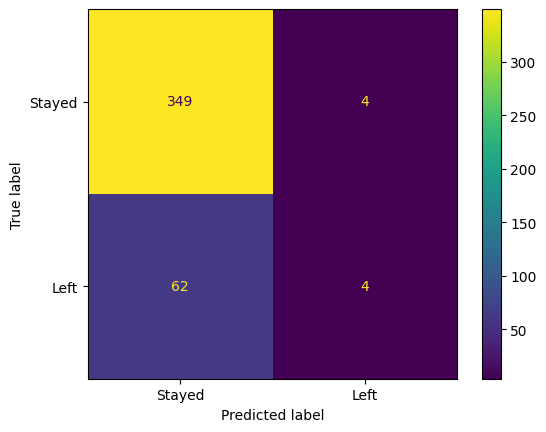

In [1075]:

# LogisticRegression

# Create object
obj = LogisticRegression(max_iter=100)  

# Train data
obj.fit(x_train, y_train) 

# Predict!
y_pred=obj.predict(x_test)
y_pred = pd.DataFrame(y_pred)
print("LogisticRegression hit rate:", 100* round(accuracy_score(y_test, y_pred),3),"%")
# Check data
cfm = confusion_matrix(y_test, y_pred) 
cm_display = ConfusionMatrixDisplay(confusion_matrix = cfm, display_labels = ['Stayed', 'Left'])
cm_display.plot()
plt.show()

In [1076]:
#np.set_printoptions(precision=3)
#print( permutation_importance(obj, x_train, y_train)['importances_mean']*100)
y_pred.describe()

,0
count,419.000000
mean,0.019093
std,0.137016
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Then we check what was the importance of different x columns. We can deduct that the 9th column "Months since last promotion" was the most influential predictor, followed by roughly half as important 4th, 5th and 7th and 8th columns which are performance rating, bosses performance rating, overtime amount and travel amount.

Text(0.5, 1.0, 'Accuracy Score: 0.8448687350835322')

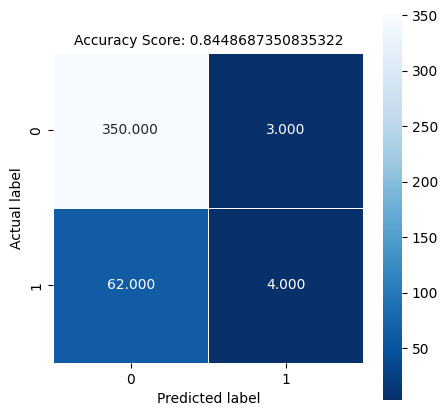

In [1077]:
#according to lecture example:

predictions = fit_logistic.predict(x_test)

conf = confusion_matrix(y_test, predictions.round(0))
acc_score = accuracy_score(y_test,predictions.round(0))

plt.figure(figsize=(5,5))
sb.heatmap(conf, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(acc_score)
plt.title(all_sample_title, size = 10)

<h4> Now lets try to standardize and scale to see if the model could find any quitters  </h4>

In [1078]:
x_test_num = x_test1[['const','training_spend', 'performance_rating', 'boss_rating_avg','salary','overtime_per_week','traveldays_per_year','lastpromotion_months','salary_difference']]

x_test1 = pd.concat([x_test_num, x_test1[['education_level','gender_male','hierarchy_level','org_role']]], axis=1)

#Scale data:
data_scaled = x_train1.copy()

# standardize the selected columns using StandardScaler
scaler = StandardScaler()

#standardized_columns = 

# Variables to be standardized (exclude Age.Group, which is a categorical variable)
X = data_scaled[['training_spend', 'performance_rating', 'boss_rating_avg','salary','overtime_per_week','traveldays_per_year','lastpromotion_months','salary_difference']] #define feature matrix X and labels y
# Standardization 
scale = scaler.fit_transform(X) 
scale = pd.DataFrame(scale)

scale.set_axis(['training_spend', 'performance_rating', 'boss_rating_avg','salary','overtime_per_week','traveldays_per_year','lastpromotion_months','salary_difference'], axis='columns', inplace=True)

# Put things back together and add constant
X_standardized = pd.concat([scale, x_train1[['education_level','gender_male','hierarchy_level','org_role']]], axis=1)
X_standardized=sm.add_constant(X_standardized)
# Check the result
#X_standardized.describe()

C:\Users\Tuomo\AppData\Local\Temp\ipykernel_7108\146857212.py:19: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  scale.set_axis(['training_spend', 'performance_rating', 'boss_rating_avg','salary','overtime_per_week','traveldays_per_year','lastpromotion_months','salary_difference'], axis='columns', inplace=True)


LogisticRegression hit rate: 84.2 %


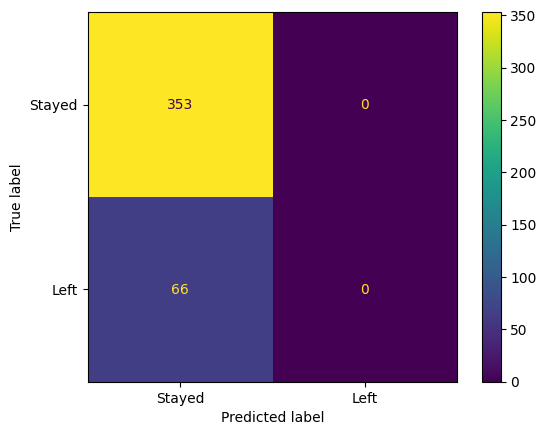

In [1079]:

# LogisticRegression

# Create object
obj = LogisticRegression(max_iter=1000)  

# Train data
#obj.fit(X_, y_train) 

obj.fit(X_standardized, y_train) 

# Predict!
y_pred=obj.predict(x_test1)
y_pred = pd.DataFrame(y_pred)
print("LogisticRegression hit rate:",100* round(accuracy_score(y_test, y_pred),3),"%")
# Check data
cfm = confusion_matrix(y_test, y_pred) 
cm_display = ConfusionMatrixDisplay(confusion_matrix = cfm, display_labels = ['Stayed', 'Left'])
cm_display.plot()
plt.show()

It seems the model is mostly the same and this time did not predict any employees to leave.

<h4> Now lets bias the train data by removing 50% of false attrition data rows</h4>

In [1081]:
df = pd.read_csv('train.csv')

####### Remove half of negative attrition rows:
import random
false_indices = df[df['attrition'] == 0].index
false_indices_to_remove = np.random.choice(false_indices, size=int(0.5*len(false_indices)), replace=False)
df = df.drop(false_indices_to_remove)

#Change education level from string to number, 1 = BSc, 2 = MSc or MBA, 3 = DSc or PhD
df['education_level'] = df['education_level'].map({"BSc":1,"MSc or MBA":2, "DSc or PhD":3})

df['hierarchy_level'] = df["job_title"].map(lambda x: 1 if ("Lead" in x or "Principal" in x) else 2 if ("Senior" in x or "Consultant" in x) else 4 if ("Junior designer" in x or "Business" in x or "Junior developer" in x) else 3 if ('Associate' in x or 'Developer' in x or "Designer" in x) else 0)
# 1:Software development, 2: Consulting, 3: Design
df['org_role'] = df["job_title"].map(lambda x: 1 if ("Developer" in x or "developer" in x) else 2 if ("Associate" in x or "Consultant" in x or "Business" in x) else 3 if ("Designer" in x or "designer" in x) else 0).astype(int)

# ILMAN JOB_TITLEÄ:
x = df
x = x.drop(['attrition'], axis=1)

x = x.drop(['job_title'], axis=1)

df['traveldays_per_year'].median()


df.tail(10)

,attrition,training_spend,education_level,job_title,gender_male,performance_rating,boss_rating_avg,salary,overtime_per_week,traveldays_per_year,lastpromotion_months,salary_difference,hierarchy_level,org_role
1712,False,1884,1,Junior designer,False,3,1.7,3965,3,27,21,34.030888,4,3
1716,True,1894,1,Developer,False,2,2.2,5489,7,12,18,-108.483333,3,1
1718,False,1373,1,Business analyst,True,4,2.6,4215,4,27,14,-26.888889,4,2
1719,True,1958,2,Junior developer,True,1,2.6,3728,0,29,32,-193.857639,4,1
1720,False,2010,2,Developer,True,2,2.5,5440,11,20,22,-157.483333,3,1
1726,False,2041,2,Designer,False,4,3.4,4827,9,36,21,-20.651515,3,3
1727,False,1860,2,Associate,False,3,2.6,5268,0,6,26,184.655172,3,2
1728,True,2083,1,Developer,True,4,4.2,6041,12,7,36,-6.771429,3,1
1729,False,1735,1,Business analyst,True,3,2.3,3926,1,19,6,-16.767677,4,2
1730,False,1979,2,Developer,True,1,1.1,5181,2,23,3,-416.483333,3,1


Optimization terminated successfully.
         Current function value: 0.573304
         Iterations 5
LogisticRegression hit rate: 83.1 %


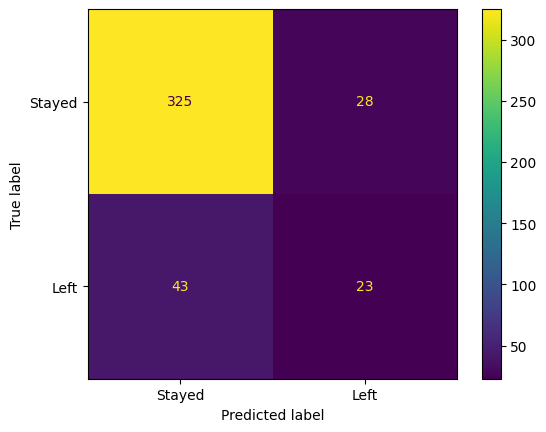

In [1085]:
#make train and test data and modify it to numeric format
x_train = x
y_train = df['attrition']
y_test = pd.read_csv('test.csv')['attrition']

x_test = pd.read_csv('test.csv').drop(['attrition'], axis=1)
x_test['education_level'] = x_test['education_level'].map({"BSc":1,"MSc or MBA":2, "DSc or PhD":3})

x_test['hierarchy_level'] = x_test["job_title"].map(lambda x: 1 if ("Lead" in x or "Principal" in x) else 2 if ("Senior" in x or "Consultant" in x) else 4 if ("Junior designer" in x or "Business" in x or "Junior developer" in x) else 3 if ('Associate' in x or 'Developer' in x or "Designer" in x) else 0)
# 1:Software development, 2: Consulting, 3: Design
x_test['org_role'] = x_test["job_title"].map(lambda x: 1 if ("Developer" in x or "developer" in x) else 2 if ("Associate" in x or "Consultant" in x or "Business" in x) else 3 if ("Designer" in x or "designer" in x) else 0).astype(int)
x_test = x_test.drop(['job_title'], axis=1)
#Make gender 0 or 1
x_train['gender_male'] = x_train['gender_male'].map({True:1, False:0})
x_test['gender_male'] = x_test['gender_male'].map({True:1, False:0})

x_train = sm.add_constant(x_train) #add intercept
x_test = sm.add_constant(x_test) #add intercept

#drop high p value columns:
columns = ['training_spend', 'performance_rating', 'boss_rating_avg','overtime_per_week','traveldays_per_year','lastpromotion_months']
#columns = ['performance_rating', 'boss_rating_avg']
x_train = x_train[columns]   
x_test = x_test[columns]   

fit_logistic = sm.Logit(y_train, x_train).fit()
y_test = y_test.map({True:1, False:0})
y_train = y_train.map({True:1, False:0})


# Draw confusion matrix

# Create object
obj = LogisticRegression(max_iter=100)  
# Train data
obj.fit(x_train, y_train) 
# Predict!
y_pred=obj.predict(x_test)
y_pred = pd.DataFrame(y_pred)
print("LogisticRegression hit rate:", 100* round(accuracy_score(y_test, y_pred),3),"%")
# Check data
cfm = confusion_matrix(y_test, y_pred) 
cm_display = ConfusionMatrixDisplay(confusion_matrix = cfm, display_labels = ['Stayed', 'Left'])
cm_display.plot()
plt.show()


Now atleast the amount of people predicted to leave is right! The model could not tell which of them though.